<a href="https://colab.research.google.com/github/travislatchman/Face-Recognition-Classification-Algorithms/blob/main/fisherfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import scipy.io


In [ ]:
# set random seed for reproducibility
np.random.seed(42)


In [ ]:
# import the file YaleB-32x32.mat
YaleB = scipy.io.loadmat('YaleB_32x32.mat')


In [ ]:
# Access variables
fea = YaleB['fea']  # every row is a face
gnd = YaleB['gnd'].ravel()  # labels


In [ ]:

# define range of m values to try
m_values = [10, 20, 30, 40, 50]

# initialize variables to store classification errors for each value of m
classification_errors = []


In [ ]:

# loop over m values
for m in m_values:
    # randomly select m images per individual to form the training set
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for label in np.unique(gnd):
        label_indices = np.where(gnd == label)[0]
        np.random.shuffle(label_indices)
        train_indices = label_indices[:m]
        test_indices = label_indices[m:]
        train_data.append(fea[train_indices])
        train_labels.append(gnd[train_indices])
        test_data.append(fea[test_indices])
        test_labels.append(gnd[test_indices])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # apply PCA to training and test data
    #pca = PCA(n_components=100, svd_solver='randomized', whiten=True)
    # pca = PCA(n_components=100)
    # pca.fit(train_data)
    # train_pca = pca.transform(train_data)
    # test_pca = pca.transform(test_data)

    # apply LDA to training data
    # lda = LinearDiscriminantAnalysis(
    #     n_components=min(37, len(np.unique(train_labels))))
    # lda.fit(train_pca, train_labels)
    # train_lda = lda.transform(train_pca)
    # test_lda = lda.transform(test_pca)

    lda = LinearDiscriminantAnalysis(
        n_components=min(37, len(np.unique(train_labels))))
    lda.fit(train_data, train_labels)
    train_lda = lda.transform(train_data)
    test_lda = lda.transform(test_data)

    # train k-NN classifier on training data and compute classification error on test data
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_lda, train_labels)
    predicted_labels = knn.predict(test_lda)
    classification_errors.append(
        np.sum(predicted_labels != test_labels) / test_labels.shape[0] * 100)


In [ ]:
classification_errors


[22.566371681415927,
 14.873035066505441,
 20.015698587127158,
 4.47427293064877,
 3.3073929961089497]

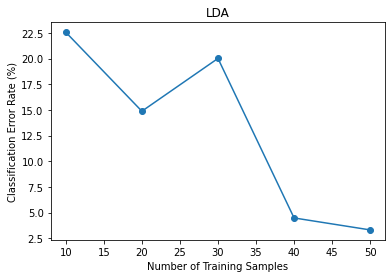

In [ ]:

# plot classification errors vs. number of training samples
plt.plot(m_values, classification_errors, '-o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Classification Error Rate (%)')
plt.title('LDA')
plt.show()


### this is just a reimplementation of the previous code block for LDA

In [ ]:


# loop over m values
for m in m_values:
    # randomly select m images per individual to form the training set
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for label in np.unique(gnd):
        label_indices = np.where(gnd == label)[0]
        np.random.shuffle(label_indices)
        train_indices = label_indices[:m]
        test_indices = label_indices[m:]
        train_data.append(fea[train_indices])
        train_labels.append(gnd[train_indices])
        test_data.append(fea[test_indices])
        test_labels.append(gnd[test_indices])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # apply Fisherfaces to training data
    lda = LinearDiscriminantAnalysis(n_components=min(
        train_data.shape[0]-1, len(np.unique(train_labels))-1))
    lda.fit(train_data, train_labels)
    train_data_lda = lda.transform(train_data)
    test_data_lda = lda.transform(test_data)

    # train k-NN algorithm on LDA-transformed training data
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(train_data_lda, train_labels)

    # predict test set labels
    pred_labels = neigh.predict(test_data_lda)

    # calculate classification error rate
    classification_error_rate = np.sum(
        pred_labels != test_labels) / len(test_labels) * 100

    # store classification error rate
    classification_errors.append(classification_error_rate)


In [ ]:
classification_errors


[22.566371681415927,
 14.873035066505441,
 20.015698587127158,
 4.47427293064877,
 3.3073929961089497]

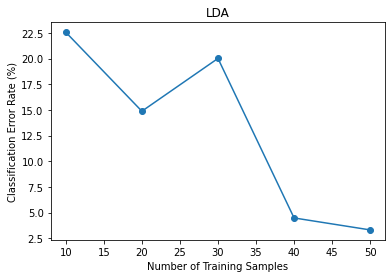

In [ ]:

# plot classification errors vs. number of training samples
plt.plot(m_values, classification_errors, '-o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Classification Error Rate (%)')
plt.title('LDA')
plt.show()


### LDA from scratch

In [ ]:
def lda_fisherfaces(train_data, train_labels, test_data, test_labels, num_components):
    # Compute mean face
    mean_face = np.mean(train_data, axis=0)

    # Compute difference faces
    phi = train_data - mean_face

    # Compute within-class scatter matrix Sw and between-class scatter matrix Sb
    classes = np.unique(train_labels)
    num_classes = len(classes)
    Sw = np.zeros((train_data.shape[1], train_data.shape[1]))
    Sb = np.zeros((train_data.shape[1], train_data.shape[1]))
    for c in classes:
        class_indices = np.where(train_labels == c)[0]
        class_data = train_data[class_indices]
        class_phi = phi[class_indices]
        class_mean = np.mean(class_data, axis=0)
        class_phi_mean = np.mean(class_phi, axis=0)
        Sw += np.dot(class_phi.T, class_phi)
        Sb += len(class_indices) * \
            np.outer((class_mean - mean_face), (class_phi_mean))

    # Compute LDA matrix
    # Solve the generalized eigenvalue problem
    eigvals, eigvecs = np.linalg.eig(np.dot(np.linalg.inv(Sw), Sb))
    eigvecs = eigvecs[:, np.argsort(eigvals)[::-1]]
    lda_matrix = eigvecs[:, :num_classes - 1]

    # Project train and test data onto LDA subspace
    lda_train_data = np.dot(train_data - mean_face, lda_matrix)
    lda_test_data = np.dot(test_data - mean_face, lda_matrix)

    # Predict test labels
    test_predictions = []
    for i in range(lda_test_data.shape[0]):
        distances = np.sum(
            np.square(lda_train_data - lda_test_data[i]), axis=1)
        closest_index = np.argmin(distances)
        closest_label = train_labels[closest_index]
        test_predictions.append(closest_label)
    test_predictions = np.array(test_predictions)

    # Compute classification error rate
    classification_error = 100 * \
        np.sum(test_predictions != test_labels) / len(test_labels)

    return classification_error


In [ ]:
# define range of m values to try
m_values = [10, 20, 30, 40, 50]

# initialize variables to store classification errors for each value of m
classification_errors = []


# loop over m values
for m in m_values:
    # randomly select m images per individual to form the training set
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for label in np.unique(gnd):
        label_indices = np.where(gnd == label)[0]
        np.random.shuffle(label_indices)
        train_indices = label_indices[:m]
        test_indices = label_indices[m:]
        train_data.append(fea[train_indices])
        train_labels.append(gnd[train_indices])
        test_data.append(fea[test_indices])
        test_labels.append(gnd[test_indices])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # apply LDA Fisherfaces
    classification_error = lda_fisherfaces(train_data, train_labels, test_data, test_labels, 37)

    classification_errors.append(classification_error)


In [ ]:
classification_errors

[98.13176007866274,
 97.03748488512697,
 19.23076923076923,
 5.9284116331096195,
 3.307392996108949]

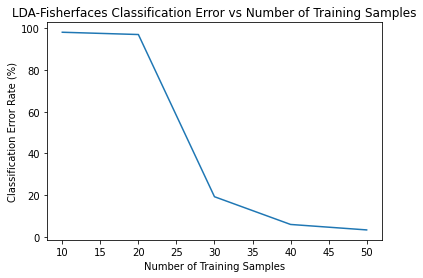

In [ ]:
# plot classification error rates against number of training samples
plt.plot(m_values, classification_errors)
plt.xlabel('Number of Training Samples')
plt.ylabel('Classification Error Rate (%)')
plt.title('LDA-Fisherfaces Classification Error vs Number of Training Samples')
plt.show()


In [ ]:
def lda(train_data, train_labels):
    """
    Computes LDA projection matrix for given training data and labels.

    Parameters:
        train_data (numpy array): Training data matrix with each row representing a feature vector.
        train_labels (numpy array): Training data labels.

    Returns:
        lda_matrix (numpy array): LDA projection matrix.
    """

    # number of classes
    classes = np.unique(train_labels)
    num_classes = len(classes)

    # class-wise mean vectors
    class_mean_vectors = []
    for c in classes:
        class_data = train_data[train_labels == c, :]
        class_mean_vectors.append(np.mean(class_data, axis=0))
    class_mean_vectors = np.array(class_mean_vectors)

    # within-class scatter matrix
    within_class_scatter_matrix = np.zeros(
        (train_data.shape[1], train_data.shape[1]))
    for c, mean_vec in zip(classes, class_mean_vectors):
        class_data = train_data[train_labels == c, :]
        class_scatter_matrix = np.zeros(
            (train_data.shape[1], train_data.shape[1]))
        for row in class_data:
            row, mean_vec = row.reshape(
                train_data.shape[1], 1), mean_vec.reshape(train_data.shape[1], 1)
            class_scatter_matrix += (row - mean_vec).dot((row - mean_vec).T)
        within_class_scatter_matrix += class_scatter_matrix

    # between-class scatter matrix
    overall_mean_vector = np.mean(train_data, axis=0)
    between_class_scatter_matrix = np.zeros(
        (train_data.shape[1], train_data.shape[1]))
    for c, mean_vec in zip(classes, class_mean_vectors):
        n = train_data[train_labels == c, :].shape[0]
        mean_vec = mean_vec.reshape(train_data.shape[1], 1)
        overall_mean_vector = overall_mean_vector.reshape(
            train_data.shape[1], 1)
        between_class_scatter_matrix += n * \
            (mean_vec - overall_mean_vector).dot((mean_vec - overall_mean_vector).T)

    # eigenvectors and eigenvalues of (Sw^-1).Sb
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(
        within_class_scatter_matrix).dot(between_class_scatter_matrix))

    # sort eigenvectors in descending order of eigenvalues
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i])
                 for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda x: x[0], reverse=True)

    # LDA projection matrix
    lda_matrix = np.hstack((eig_pairs[i][1].reshape(
        train_data.shape[1], 1) for i in range(num_classes - 1)))

    return lda_matrix


In [ ]:
# define range of m values to try
m_values = [10, 20, 30, 40, 50]

# initialize variables to store classification errors for each value of m
classification_errors = []


# loop over m values
for m in m_values:
    # randomly select m images per individual to form the training set
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for label in np.unique(gnd):
        label_indices = np.where(gnd == label)[0]
        np.random.shuffle(label_indices)
        train_indices = label_indices[:m]
        test_indices = label_indices[m:]
        train_data.append(fea[train_indices])
        train_labels.append(gnd[train_indices])
        test_data.append(fea[test_indices])
        test_labels.append(gnd[test_indices])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # apply LDA Fisherfaces
    lda_matrix = lda(
        train_data, train_labels)

    mean_face = np.mean(train_data, axis=0)
    # Project train and test data onto LDA subspace
    lda_train_data = np.dot(train_data - mean_face, lda_matrix)
    lda_test_data = np.dot(test_data - mean_face, lda_matrix)

    # Predict test labels
    test_predictions = []
    for i in range(lda_test_data.shape[0]):
        distances = np.sum(
            np.square(lda_train_data - lda_test_data[i]), axis=1)
        closest_index = np.argmin(distances)
        closest_label = train_labels[closest_index]
        test_predictions.append(closest_label)
    test_predictions = np.array(test_predictions)

    # Compute classification error rate
    classification_error = 100 * \
        np.sum(test_predictions != test_labels) / len(test_labels)

    classification_errors.append(classification_error)



/var/folders/8y/f5g9vg312nj09bbbdbnk_klr0000gn/T/ipykernel_59288/3687969912.py:59: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  lda_matrix = np.hstack((eig_pairs[i][1].reshape(


In [ ]:
classification_errors


[88.69223205506391,
 92.80532043530835,
 17.81789638932496,
 5.145413870246085,
 5.447470817120623]